# Print Track Workbook

This workbook creates the SVG file of a track based on the waypoints.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    PlottingUtils as pu

In [2]:
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    pu._plot_coords(ax, line)                                                       
    pu._plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    pu._plot_coords(ax, line)                                                       
    pu._plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    pu._plot_coords(ax, line)                                                       
    pu._plot_line(ax, line)     

## Load the track to work on

In [3]:
# Conveniently list available tracks to analyze
tu = TrackIO(base_path='../routes')

In [4]:
# Replace the name here with the track to analyze
TRACK_NAME = 'Bean'
CENTER_LINE_WIDTH = 25
OUTER_LINE_WIDTH = 75
TRACK_WIDTH = 940
SIZE_ADJUST = 0

In [5]:
# Load the track and waypoints
track = tu.load_track(TRACK_NAME)
waypoints = track.waypoints

Loaded 101 waypoints


/home/ludvigse/.local/lib/python3.10/site-packages/deepracer/tracks/track_utils.py:220: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  np.vstack((l_outer_border, np.flipud(l_inner_border))))
/home/ludvigse/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:286: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arrs = atleast_2d(*tup)


Is loop/ring?  True
Length: 8.25,11.20,14.15
Width: 0.940


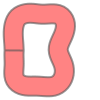

In [8]:
# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)


road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
print("Length: {:0.2f},{:0.2f},{:0.2f}".format(l_inner_border.length, l_center_line.length, l_outer_border.length))
print("Width: {:0.3f}".format(l_inner_border.interpolate(0).distance(l_outer_border.interpolate(0))))
road_poly

## Display the original track waypoints

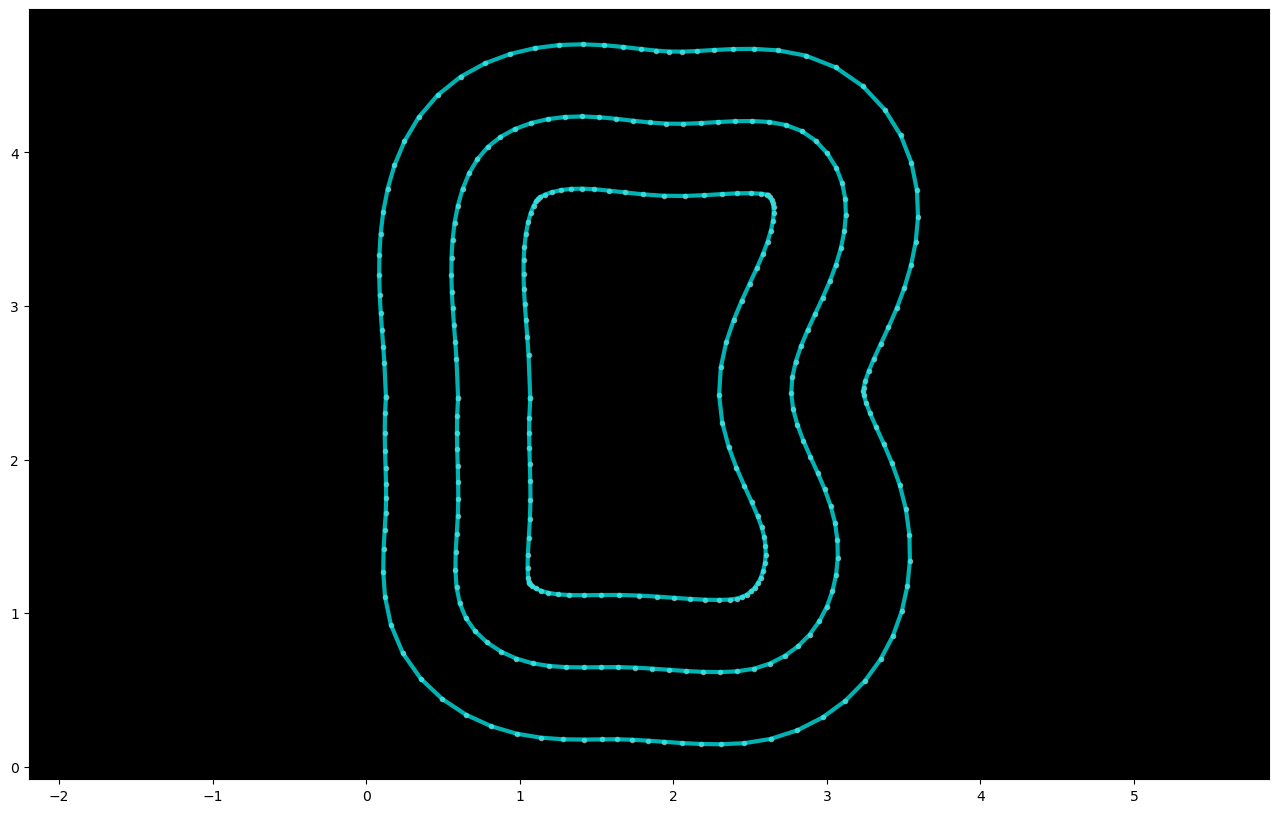

In [9]:
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

## Create new Polygons

In [10]:
# Convert into millimeter (needed for SVG) - reduce size of center-line with 10 cm.
center_polygon_reduced = Polygon(center_line*1000).buffer(SIZE_ADJUST)

# Normalize position (x and y) 
x_val = np.array(center_polygon_reduced.exterior.xy[0])
x_moved = x_val - min(x_val) + TRACK_WIDTH/2

y_val = np.array(center_polygon_reduced.exterior.xy[1])
y_moved = y_val - min(y_val) + TRACK_WIDTH/2

# Stack into two-column numpy
smooth_center_moved = np.column_stack((x_moved, y_moved))

In [11]:
# Filled polygon -- exterior is center-line
center_polygon_moved_reduced = Polygon(smooth_center_moved)

# Polygons for outer line (both inner and outer side)
center_polygon_outer = center_polygon_moved_reduced.buffer(TRACK_WIDTH/2, join_style=1)
center_polygon_outer_border = center_polygon_outer.buffer(-OUTER_LINE_WIDTH, join_style=1)

# Polygons for inner line (both inner and outer side)
center_polygon_inner = center_polygon_moved_reduced.buffer(-TRACK_WIDTH/2, join_style=1)
center_polygon_inner_border = center_polygon_inner.buffer(OUTER_LINE_WIDTH, join_style=1)

# Diff polygons for inner line, outer line and the track surface
inner_border_p = center_polygon_inner_border.difference(center_polygon_inner)
outer_border_p = center_polygon_outer.difference(center_polygon_outer_border)
track_p = center_polygon_outer.difference(center_polygon_inner)

# Start line
start_center_point = center_polygon_moved_reduced.exterior.interpolate(0.0, normalized=True)

start_inner_d = center_polygon_inner.exterior.project(start_center_point, normalized=True)
start_inner_p = center_polygon_inner.exterior.interpolate(start_inner_d, normalized=True)

start_outer_d = center_polygon_outer.exterior.project(start_center_point, normalized=True)
start_outer_p = center_polygon_outer.exterior.interpolate(start_outer_d, normalized=True)

start_line_ls = LineString([start_inner_p, start_outer_p])

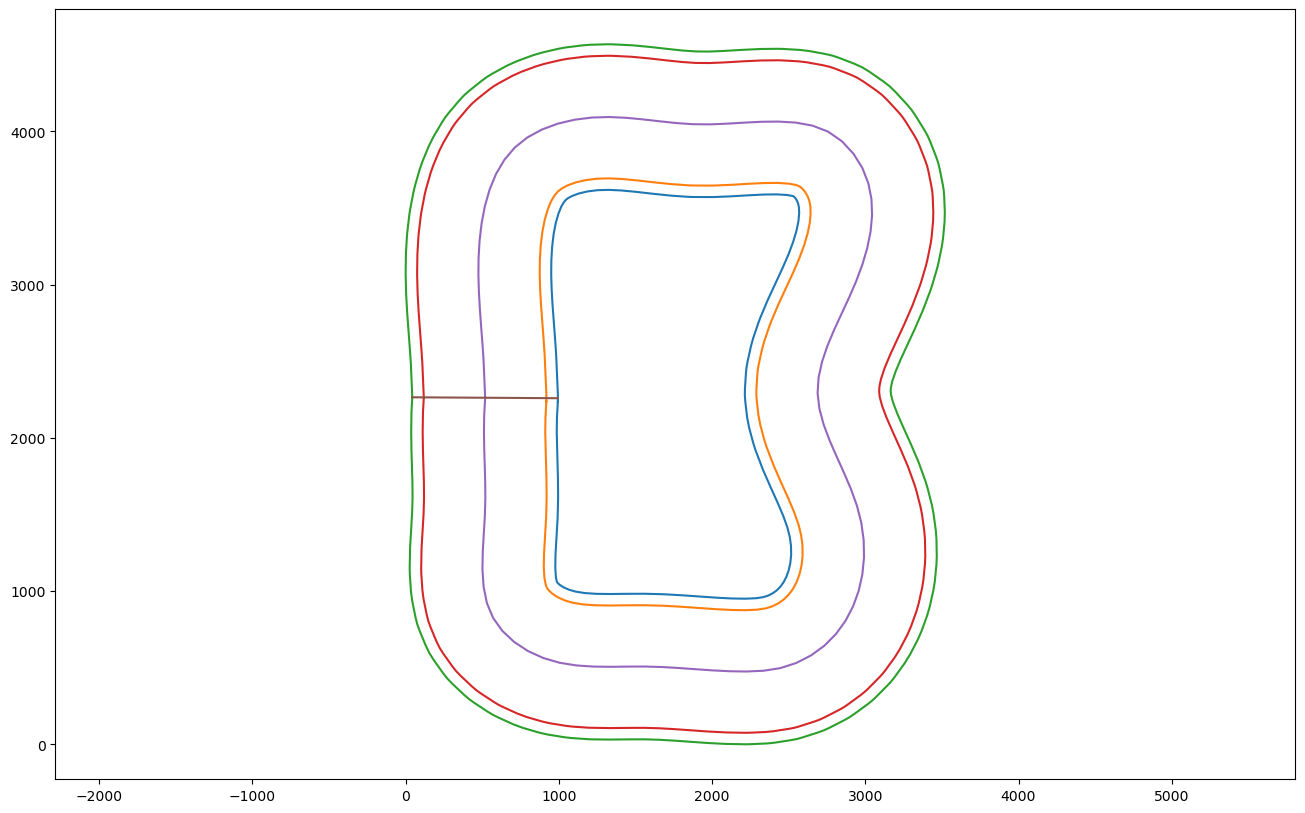

In [12]:
fig = plt.figure(1, figsize=(16, 10))

x_i, y_i = center_polygon_inner.exterior.xy
plt.plot(x_i, y_i)
x_ib, y_ib = center_polygon_inner_border.exterior.xy
plt.plot(x_ib, y_ib)
x_o, y_o = center_polygon_outer.exterior.xy
plt.plot(x_o, y_o)
x_ob, y_ob = center_polygon_outer_border.exterior.xy
plt.plot(x_ob, y_ob)

x, y = center_polygon_moved_reduced.exterior.xy
plt.plot(x,y)

x_s, y_s = start_line_ls.xy
plt.plot(x_s,y_s)

# to net let the image be distorted along the axis
plt.axis('equal')
plt.show()

In [15]:
dim_x = max(x_o)-min(x_o)
dim_y = max(y_o)-min(y_o)
print(f"Track dimensions x:{(dim_x/1000):0.2f}, y:{(dim_y/1000):0.2f}")
print(f"Length: {(l_center_line.length):0.2f}")

Track dimensions x:3.52, y:4.57
Length: 11.20


In [16]:
import xml.etree.ElementTree as ET

def create_svg(obj: Polygon, id: str, fill_color: str=None, fill_opacity: float=1, border_color: str=None, border_width: int=0, border_style: str=None, border_offset: int=0):
    tree = ET.ElementTree(ET.fromstring(obj.svg()))
    root = tree.getroot() 
    root.set('id', id)
    
    # Strip not-needed attributes
    root.attrib.pop("fill", None)
    root.attrib.pop("fill-rule", None)
    root.attrib.pop("stroke", None)
    root.attrib.pop("stroke-width", None)
    root.attrib.pop("opacity", None)
    
    style = ""
    
    if fill_color is None:
        style += "fill:none;"
    else:
        style += f"fill:{fill_color};"
        style += f"fill-opacity:{fill_opacity};"

    if border_color is None:
        style += "stroke:none;"
    else:
        style += f"stroke:{border_color};"
        style += f"stroke-width:{border_width};"
        style += "stroke-opacity:1;"

        if border_style is not None:
            style += f"stroke-dasharray:{border_style};"
            style += f"stroke-dashoffset:{border_offset};"

    root.set('style', style)
        
#    return ET.tostring(root, encoding='unicode')
    return root

In [20]:
doc_props = {
    'id': TRACK_NAME,
    'version': '1.1',
    'baseProfile': 'full',
    'width': '{width:.5f}mm'.format(width = dim_x),
    'height': '{height:.5f}mm'.format(height = dim_y),
    'viewBox': '%.5f,%.5f,%.5f,%.5f' % (0, 0, dim_x, dim_y),
    'xmlns': 'http://www.w3.org/2000/svg',
    'xmlns:ev': 'http://www.w3.org/2001/xml-events',
    'xmlns:xlink': 'http://www.w3.org/1999/xlink',
    'xmlns:sodipodi': 'http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd',
    'xmlns:inkscape': 'http://www.inkscape.org/namespaces/inkscape'
}

view_props = {
    'id': 'trackview',
    'pagecolor': '#00c389',
    'bordercolor': '#000000',
    'borderopacity': '0.25'   
}

with open(f"{TRACK_NAME}.svg", 'wb') as f:
    
    svg = ET.Element("svg")
    tree = ET.ElementTree(svg)

    for key in doc_props:
        val = doc_props[key]
        svg.set(key, val)

    view = ET.SubElement(svg, "sodipodi:namedview")
    for key in view_props:
        val = view_props[key]
        view.set(key, val)

    svg.insert(1, create_svg(track_p, "road", fill_color="#232f3e", border_color=None))
    svg.insert(2, create_svg(inner_border_p, "il", fill_color="#ffffff", border_color=None))
    svg.insert(3, create_svg(outer_border_p, "ol", fill_color="#ffffff", border_color=None))
    svg.insert(4, create_svg(center_polygon_moved_reduced, "cl", fill_color=None, border_color="#ff9900", border_width=CENTER_LINE_WIDTH, border_style="50,50"))
    svg.insert(5, create_svg(start_line_ls, "start_line", fill_color=None, border_color="#ffffff", border_width=100, border_style=None))

    tree.write(f, encoding='utf-8', xml_declaration=True)
